## Imports

In [70]:
"""Imports"""

import re
import json
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## filter_res_by_cut_number

In [71]:
def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output

## normalize_to_selected_frag_number

In [72]:
def normalize_to_selected_frag_number(res_data: list, properties_to_normalize: list[str], selected_frag_number: str, reciprocal: list[bool], keep_selected_frag_number: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["partition_search_method"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_frag_number = {d['number_of_fragments']: d[property] for d in lst}
                if property_of_each_frag_number[selected_frag_number] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_frag_number[selected_frag_number]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_frag_number[selected_frag_number]
                out_d.update({f"{property}_normalized_to_{selected_frag_number}": normalized_value})
            output.append(out_d)

    if not keep_selected_frag_number:
        output = [d for d in output if d['number_of_fragments'] != selected_frag_number]

    return output


## normalize_to_selected_search_method

In [73]:
def normalize_to_selected_search_method(res_data: list, properties_to_normalize: list[str], selected_search_method: str, reciprocal: list[bool], keep_selected_search_method: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_method = {d['partition_search_method']: d[property] for d in lst}
                if property_of_each_method[selected_search_method] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_method[selected_search_method]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_method[selected_search_method]
                out_d.update({f"{property}_normalized_to_{selected_search_method}": normalized_value})
            output.append(out_d)

    if not keep_selected_search_method:
        output = [d for d in output if d['partition_search_method'] != keep_selected_search_method]

    return output


## scattered_plot

In [74]:
def scattered_plot(x_axis, y_axis, yscale, y_lims, xscale, group_param, res_data, cut_number_range, search_mode1, search_mode2, reg_order):
    """

    :param x_axis:
    :param y_axis:
    :param yscale: 'symlog', 'linear', 'log'
    :param y_lims: {'method1':[0.5,1000], 'method2':[0.5,1000]}
    :param group_param:
    :param res_data:
    :param cut_number_range:
    :param search_mode1:
    :param search_mode2:
    :return:
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 6))
    plt.subplots_adjust(wspace=0.5)
    fig.patch.set_facecolor('white')  # Set the background of the figure to white

    for ax, search_method in zip((ax1, ax2), [search_mode1, search_mode2]):

        df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == search_method and d['number_of_cuts'] in cut_number_range])

        if not group_param:
            sns.regplot(data=df,
                        ax=ax,
                        x=x_axis,
                        y=y_axis,
                        scatter=True,
                        color=sns.color_palette("husl", 1)[0],
                        scatter_kws={'alpha':0.8,'s':5},
                        line_kws={'linewidth':1.5})
        else:
            group_param_unique_items = set([d[group_param] for d in res_data])
            colors = sns.color_palette("husl", len(group_param_unique_items))
            color_map = {i:color for i, color in zip(group_param_unique_items, colors)}
            grouped = df.groupby(group_param)
            for key, group in grouped:
                sns.regplot(ax=ax,
                            x=group[x_axis],
                            y=group[y_axis],
                            scatter=True,
                            label=key,
                            color=color_map[key],
                            scatter_kws={'alpha':0.8,'s':5},
                            line_kws={'linewidth':1.5},
                            order=reg_order)

        ax.set_ylabel(str.title(re.sub('_',' ',y_axis)))
        ax.set_xlabel(str.title(re.sub('_',' ',x_axis)))
        # ax.legend(title=group_param, loc='upper left', ncols=2)
        ax.set_yscale(yscale)
        ax.set_ylim(y_lims[search_method])
        ax.set_xscale(xscale)
        ax.set_facecolor('white')  # Set the background of the axes to white
        ax.set_title(f'{y_axis} per {x_axis} and {group_param} \n'
             f'\n '
             f'{search_method}')

        sel_param = y_axis
        max_y = max(df[sel_param].values)
        for idx, (x, y) in enumerate(zip(df[x_axis].values,df[sel_param].values)):
            if y == max_y:
                ax.annotate(f"{round(y, 2)}", (x, y))

    return plt

## jitter_box_plot

In [75]:
def jitter_box_plot(x_axis, y_axis, df, my_palette, logy=True):

    plt.figure(figsize=(8, 4))
    if logy:
        plt.yscale('symlog')
    else:
        plt.yscale('linear')

    # Using seaborn to plot with jitter and boxplot
    sns.boxplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette[:6], showfliers = False,
                boxprops=dict(facecolor='white', edgecolor="black", alpha=0.5),
                medianprops=dict(alpha=0.5),
                whiskerprops=dict(alpha=0.5),
                capprops=dict(alpha=0.5))
    sns.stripplot(x=x_axis, y=y_axis, hue='partition_search_method', data=df, palette=my_palette[:6], dodge=True,
                  jitter=True, alpha=0.5, s=4, edgecolor='auto')
    plt.xlabel(str.title(re.sub('_',' ',x_axis)))
    if y_axis == "normalized":
        plt.ylabel(f"Elapsed Time {str.title(re.sub('_',' ',y_axis))}")
    else:
        plt.ylabel(f"{str.title(re.sub('_',' ',y_axis))}")
    plt.title(f'Jittered Scatter Plot with Boxplot by Search Method and {str.title(re.sub("_"," ",x_axis))}')

    if y_axis == "ligation_fidelity":
        plt.ylim([0.8,1.2])

    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = plt.legend(by_label.values(), by_label.keys(), title='Search Method', loc='upper left')
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((0, 0, 0, 0))

    return plt

## Import and prepare data

In [76]:
"""Import and prepare data"""

result_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\random_inputs_20240525_dist_mut_1_2",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\random_inputs_20240525_dist_mut_1_3",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\partition_search_opt\random_inputs_20240525_1",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\partition_search_opt\random_inputs_20240525_2"
]

result_files = [join(result_dir, "results", f)
                for result_dir in result_dirs
                for f in listdir(join(result_dir, "results")) if isfile(join(result_dir,"results", f)) and re.search('best_partitions_by_cut_number',f)]

print(result_files)
pat_re_dic = {
    "cost_scan_":"cost scan",
    "cost_scan_dist_mut_":"distribute mut + cost scan",
    "dist_mut_":"distribute mut",
    "dist_mut_1_":"distribute mut and only keep the best",
    "dist_mut_1_cost_scan_":"distribute mut and only keep the best + cost scan",
    "exhaustive_":"exhaustive",
    "cost_scan_dist_mut_1_":"distribute mut and only keep the best + cost scan"
}

res_data = []
for file_path in result_files:
    name = ""
    if re.search("random",file_path):
        name = re.sub("^.+best_partitions_by_cut_number_|\d+[.]json","",file_path)
        name = pat_re_dic[name]
    with open(file_path, 'r') as fp:
        res_dict = json.load(fp)
        for res_per_cut in res_dict["best_partitions_by_cut_number"]:
            res_dict_ = res_dict.copy()
            number_checked = res_per_cut["number_of_partitions_checked"]
            uq_number_checked = res_per_cut["num_of_checked_unique_partitions"]
            hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
            if len(res_per_cut["sel_partitions"]) > 0:
                ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                cost = res_per_cut["sel_partitions"][0]["cost"]
            else:
                continue
                # ligation_fidelity = fragment_length_unevenness = cost = float("nan")
            res_dict_.update({
                'partition_search_method':name,
                'seq_length':len(res_dict["sequence"]),
                'mutation_positions':len(res_dict["mutations"]),
                'mutation_variations':sum([len(mut['aa']) for mut in res_dict["mutations"]]),
                'number_of_cuts':res_per_cut['number_of_cuts'],
                'number_of_fragments':res_per_cut['number_of_cuts']+1,
                'elapsed_time':res_per_cut['elapsed_time']/60,
                "ligation_fidelity":ligation_fidelity,
                "fragment_length_unevenness":fragment_length_unevenness,
                "cost":cost,
                "number_of_partitions_checked":number_checked,
                "num_of_checked_unique_partitions":uq_number_checked,
                "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                             })
            res_dict_.pop("best_partitions_by_cut_number", None)
            res_dict_.pop("mutations", None)
            res_data.append(res_dict_)
#
# res_data = normalize_to_selected_search_method(res_data=res_data,
#                                                properties_to_normalize=['elapsed_time'],
#                                                selected_search_method="exhaustive",
#                                                reciprocal=[True],
#                                                keep_selected_search_method=True)

# res_data = normalize_to_selected_frag_number(res_data=res_data,
#                                              properties_to_normalize=['cost'],
#                                              selected_frag_number='4',
#                                              reciprocal=[True],
#                                              keep_selected_frag_number=True)

['C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\\random_inputs_20240525_dist_mut_1_2\\results\\best_partitions_by_cut_number_dist_mut_1_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\\random_inputs_20240525_dist_mut_1_2\\results\\best_partitions_by_cut_number_dist_mut_1_2.json', 'C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\\random_inputs_20240525_dist_mut_1_2\\results\\best_partitions_by_cut_number_dist_mut_1_3.json', 'C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\\random_inputs_20240525_dist_mut_1_2\\results\\best_partitions_by_cut_number_dist_mut_1_4.json', 'C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\\random_inputs_20240525_dist_mut_1_2\\results\\best_partitions_by_cut_number_dist_mut_1_cost_scan_1.json', 'C:\\Users\\GOFKV\\PycharmProjects\\proseqteleporter\\experiments\\characterization\

In [77]:
res_data

[{'sequence': 'SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNFQQPFQAGLWYIGMGFAYQAHAQDMPIADM',
  'total_elapsed_time': 64.1,
  'diversity': 21897216,
  'partition_search_method': 'distribute mut and only keep the best',
  'seq_length': 75,
  'mutation_positions': 10,
  'mutation_variations': 53,
  'number_of_cuts': 2,
  'number_of_fragments': 3,
  'elapsed_time': 0.014833333333333334,
  'ligation_fidelity': 1.0,
  'fragment_length_unevenness': 0.13,
  'cost': 18648.0,
  'number_of_partitions_checked': 52,
  'num_of_checked_unique_partitions': 52,
  'pass_constraint_percentage': 100.0},
 {'sequence': 'SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNFQQPFQAGLWYIGMGFAYQAHAQDMPIADM',
  'total_elapsed_time': 64.1,
  'diversity': 21897216,
  'partition_search_method': 'distribute mut and only keep the best',
  'seq_length': 75,
  'mutation_positions': 10,
  'mutation_variations': 53,
  'number_of_cuts': 3,
  'number_of_fragments': 4,
  'elapsed_time': 0.012333333333333333,
  'ligation_fidelity': 

In [78]:
df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == "distribute mut and only keep the best"])
df

sequence  total_elapsed_time  \
0   SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNF...               64.10   
1   SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNF...               64.10   
2   SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNF...               64.10   
3   SYKECCFPKRHKKITETHGKYFNWLPRWVWHTDRFPSRTDDYSVNF...               64.10   
4   SNGLRYKMQIWPYHDNCVNEETTSHDLATIFCYGRVLQASHRSHNY...              869.39   
5   SNGLRYKMQIWPYHDNCVNEETTSHDLATIFCYGRVLQASHRSHNY...              869.39   
6   SNGLRYKMQIWPYHDNCVNEETTSHDLATIFCYGRVLQASHRSHNY...              869.39   
7   HRWNIRSISEISYTSTPCCTCRSTMKVQDWFQALVGIIRDNDFKQQ...             4523.25   
8   HRWNIRSISEISYTSTPCCTCRSTMKVQDWFQALVGIIRDNDFKQQ...             4523.25   
9   HRWNIRSISEISYTSTPCCTCRSTMKVQDWFQALVGIIRDNDFKQQ...             4523.25   
10  HRWNIRSISEISYTSTPCCTCRSTMKVQDWFQALVGIIRDNDFKQQ...             4523.25   
11  DHCWEQRAFAYVSCIELITWACCWSEYIALAKFFGPSNRCFVTEFP...                4.28   
12  DHCWEQRAFAYVSCIELITWACCWSEYIALAKFFGPSNRCFVTEFP...                4.28   
13  FWYEGPARFAIAFPGALEKIDWGTTNRSWRTQKMYLEMSVKNIVNI...              526.38   
14  FWYEGPARFAIAFPGALEKIDWGTTNRSWRTQKMYLEMSVKNIVNI...              526.38   
15  FWYEGPARFAIAFPGALEKIDWGTTNRSWRTQKMYLEMSVKNIVNI...              526.38   
16  IDYKQPYCAGKWRCQHHSQNLSNHQFNPIQRDWKGNRKPTWALTFM...            58406.74   
17  IDYKQPYCAGKWRCQHHSQNLSNHQFNPIQRDWKGNRKPTWALTFM...            58406.74   
18  IDYKQPYCAGKWRCQHHSQNLSNHQFNPIQRDWKGNRKPTWALTFM...            58406.74   
19  IDYKQPYCAGKWRCQHHSQNLSNHQFNPIQRDWKGNRKPTWALTFM...            58406.74   
20  MLDTERERFFNSFKLAGIYTEFTAKPNWWWGHIDGQTGDCQTYSHC...           307170.86   
21  MLDTERERFFNSFKLAGIYTEFTAKPNWWWGHIDGQTGDCQTYSHC...           307170.86   
22  MLDTERERFFNSFKLAGIYTEFTAKPNWWWGHIDGQTGDCQTYSHC...           307170.86   
23  MLDTERERFFNSFKLAGIYTEFTAKPNWWWGHIDGQTGDCQTYSHC...           307170.86   
24  MLDTERERFFNSFKLAGIYTEFTAKPNWWWGHIDGQTGDCQTYSHC...           307170.86   
25  MGWWKHTPVNACRPRNAEVDPNAMNNHVSVWGYLYFPFAYTCGWGC...               19.84   
26  TVGCPSYGQNQRDNNQAIRLNSGPYRKIDWNLGEACLFSDMHLMCE...                3.52   
27  TVGCPSYGQNQRDNNQAIRLNSGPYRKIDWNLGEACLFSDMHLMCE...                3.52   
28  TVGCPSYGQNQRDNNQAIRLNSGPYRKIDWNLGEACLFSDMHLMCE...                3.52   
29  MHHVMSYKNDRMCRNYVNSQPDHLCVWPFNKVWMNIMRGKSWTPVM...              152.37   
30  MHHVMSYKNDRMCRNYVNSQPDHLCVWPFNKVWMNIMRGKSWTPVM...              152.37   
31  MHHVMSYKNDRMCRNYVNSQPDHLCVWPFNKVWMNIMRGKSWTPVM...              152.37   
32  GCCYADTSCDLHIPYEDDTTMWIWRPGRRRGKFLPDIREDDDPYRR...               35.40   
33  YVFGAIEYINERGQRVCHPMEKINLHLERIGYYQERIHEYDNGFML...               21.82   
34  YVFGAIEYINERGQRVCHPMEKINLHLERIGYYQERIHEYDNGFML...               21.82   
35  YVFGAIEYINERGQRVCHPMEKINLHLERIGYYQERIHEYDNGFML...               21.82   
36  YVFGAIEYINERGQRVCHPMEKINLHLERIGYYQERIHEYDNGFML...               21.82   
37  YVFGAIEYINERGQRVCHPMEKINLHLERIGYYQERIHEYDNGFML...               21.82   
38  DTACNNHLQATQLTMRIFTVPKASMTIPVNHRNEKKWETTDQFVYH...             7225.20   
39  DTACNNHLQATQLTMRIFTVPKASMTIPVNHRNEKKWETTDQFVYH...             7225.20   
40  YAIYRVRYKCGPCRNKFTCCPWMKRNFDMMGKGTMLGVWGHSPDNM...             1101.68   
41  YAIYRVRYKCGPCRNKFTCCPWMKRNFDMMGKGTMLGVWGHSPDNM...             1101.68   

           diversity                partition_search_method  seq_length  \
0           21897216  distribute mut and only keep the best          75   
1           21897216  distribute mut and only keep the best          75   
2           21897216  distribute mut and only keep the best          75   
3           21897216  distribute mut and only keep the best          75   
4        35765452800  distribute mut and only keep the best         100   
5        35765452800  distribute mut and only keep the best         100   
6        35765452800  distribute mut and only keep the best         100   
7            1496880  distribute mut and only keep the best         125   
8            1496880  distribute mut and only keep the bes

## plotting

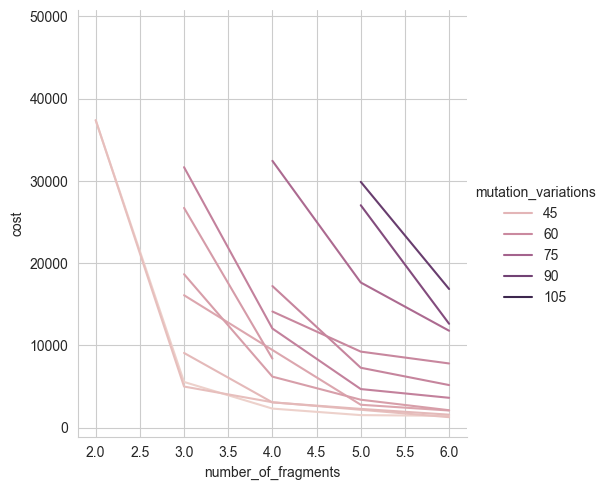

In [79]:
plot = sns.relplot(df, x='number_of_fragments', y='cost', hue='mutation_variations', legend=True, kind='line')

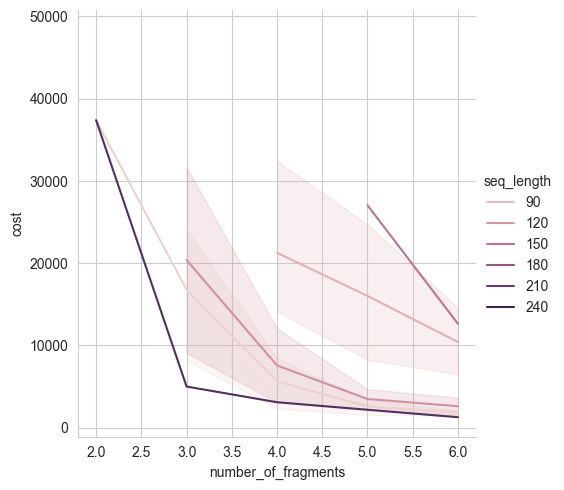

In [80]:
plot = sns.relplot(df, x='number_of_fragments', y='cost', hue='seq_length', legend=True, kind='line')

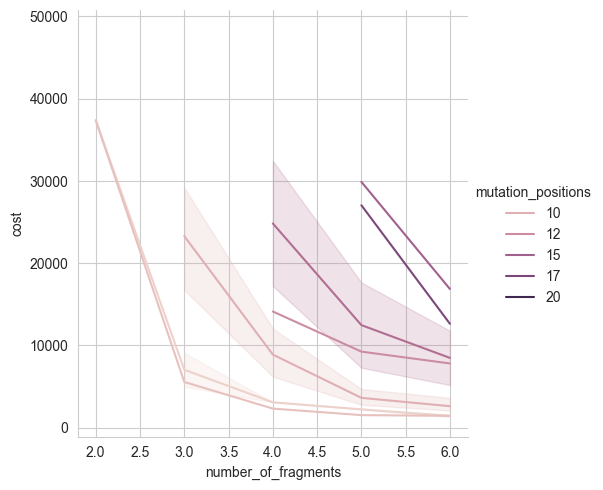

In [81]:
plot = sns.relplot(df, x='number_of_fragments', y='cost', hue='mutation_positions', legend=True, kind='line')

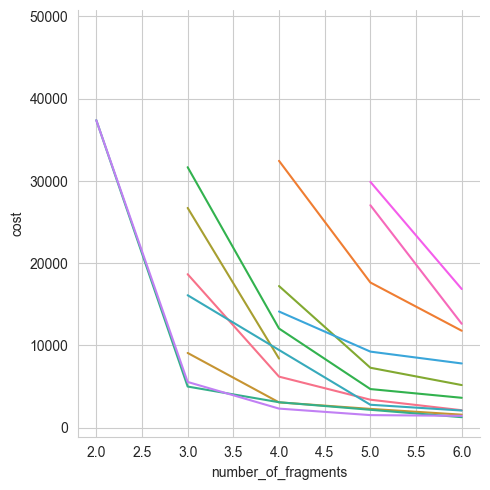

In [82]:
sns.relplot(df, x='number_of_fragments', y='cost', hue='sequence', legend=False, kind="line")

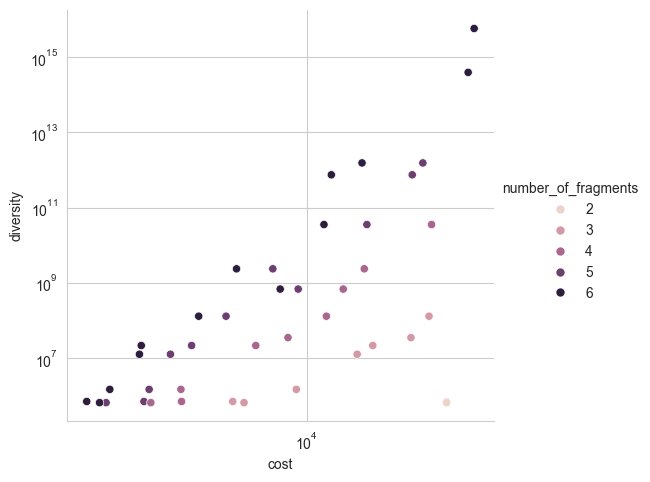

In [83]:
plot = sns.relplot(df, x='cost', y='diversity', hue='number_of_fragments', legend="auto")
plot.set(xscale="log", yscale="log")

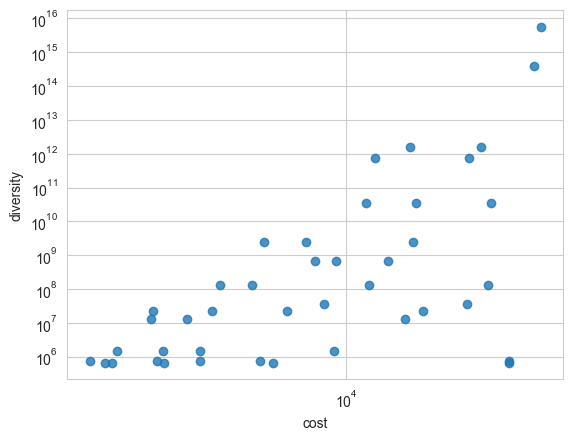

In [84]:
plot = sns.regplot(df, x='cost', y='diversity', fit_reg=False)
plot.set_yscale('symlog')
plot.set_xscale('symlog')

In [85]:
[d['cost'] for d in res_data]

[18648.0,
 6192.0,
 3384.0,
 2106.0,
 32436.0,
 17640.0,
 11772.0,
 9072.0,
 3060.0,
 2268.0,
 1566.0,
 18648.0,
 6192.0,
 3384.0,
 2106.0,
 32436.0,
 17640.0,
 11772.0,
 9072.0,
 3060.0,
 2268.0,
 1566.0,
 26712.0,
 8388.0,
 17208.0,
 7272.0,
 5166.0,
 31662.0,
 12042.0,
 4680.0,
 3618.0,
 37384.2,
 4986.0,
 3078.0,
 2160.0,
 1260.0,
 48438.0,
 26712.0,
 8388.0,
 17208.0,
 7272.0,
 5166.0,
 31662.0,
 12042.0,
 4680.0,
 3618.0,
 37384.2,
 4986.0,
 3078.0,
 2160.0,
 1260.0,
 16092.0,
 8100.0,
 2772.0,
 2070.0,
 14112.0,
 9234.0,
 7794.0,
 45774.0,
 16092.0,
 8100.0,
 2772.0,
 2070.0,
 16092.0,
 2772.0,
 2070.0,
 14112.0,
 9234.0,
 7794.0,
 45774.0,
 16092.0,
 2772.0,
 2070.0,
 14112.0,
 9234.0,
 7794.0,
 45774.0,
 14112.0,
 9234.0,
 7794.0,
 45774.0,
 16092.0,
 8100.0,
 2772.0,
 2070.0,
 14112.0,
 9234.0,
 7794.0,
 45774.0,
 37368.0,
 5544.0,
 2304.0,
 1512.0,
 1422.0,
 29880.0,
 13824.0,
 27036.0,
 11448.0,
 37368.0,
 5544.0,
 2304.0,
 1512.0,
 1422.0,
 37368.0,
 5544.0,
 2304.0,
 1512

## Plotting - Jitter + Box Plots

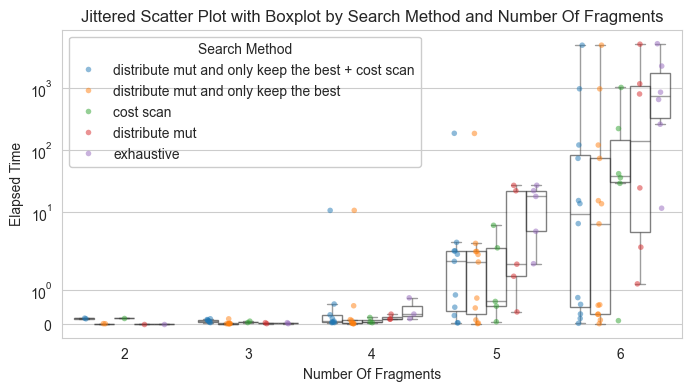

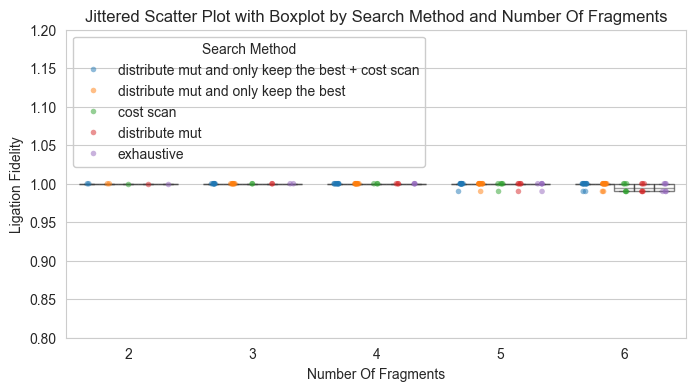

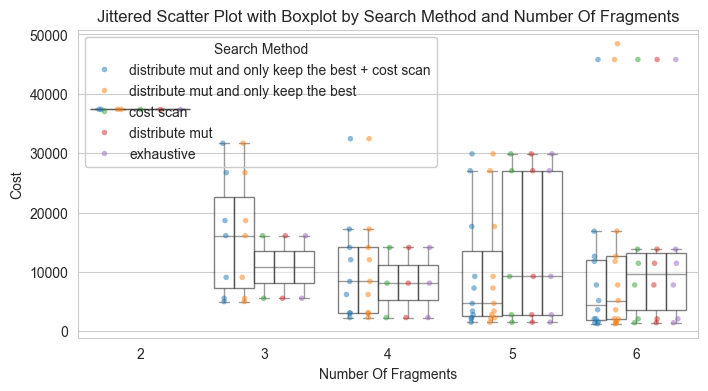

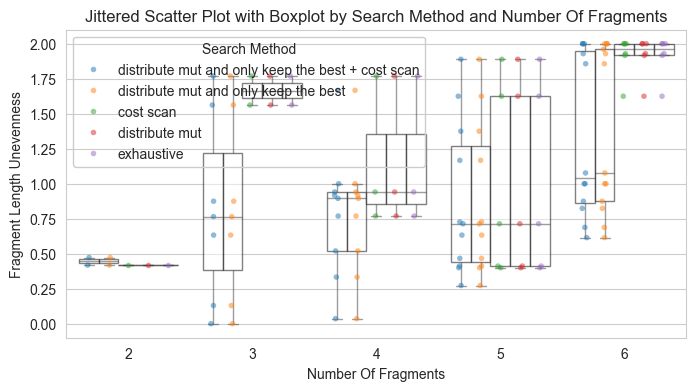

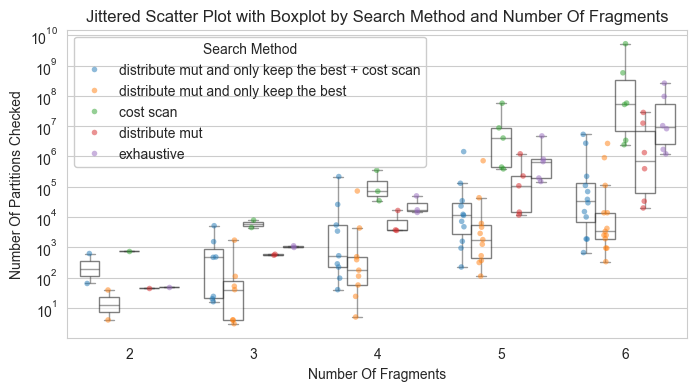

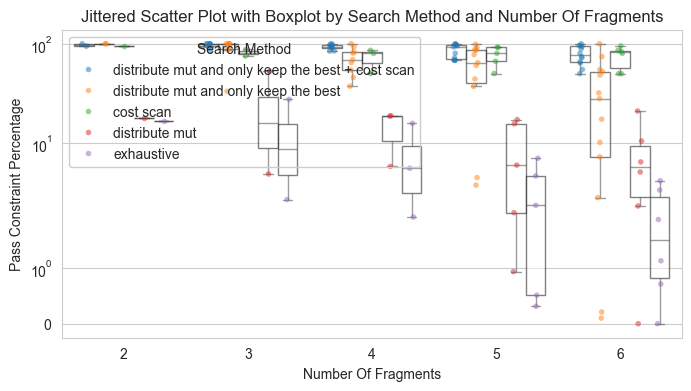

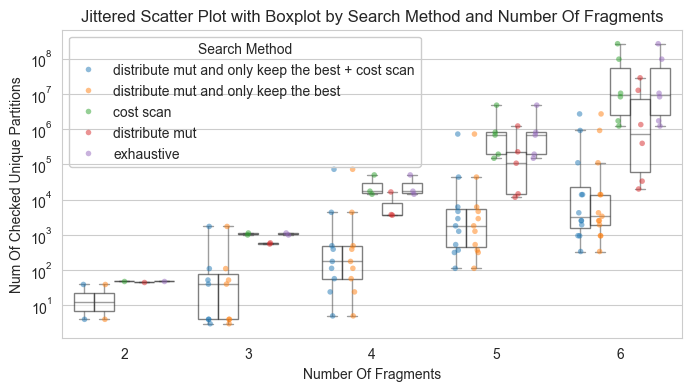

ValueError: Could not interpret value `elapsed_time_normalized_to_exhaustive` for `y`. An entry with this name does not appear in `data`.

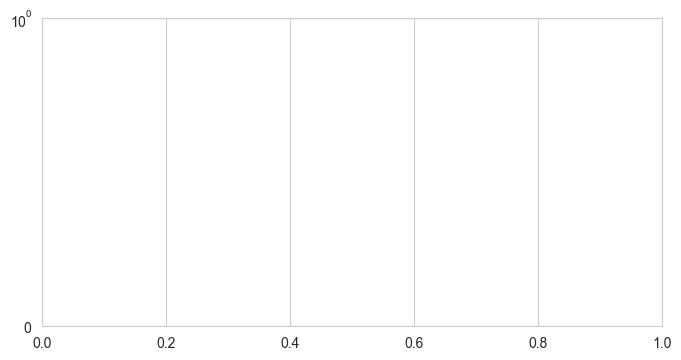

In [86]:
"""Plotting - Jitter + Box Plots"""

input_logy_spec = {
    "elapsed_time":True,
    "ligation_fidelity":False,
    "cost":False,
    "fragment_length_unevenness":False,
    "number_of_partitions_checked":True,
    "pass_constraint_percentage":True,
    "num_of_checked_unique_partitions":True,
    "elapsed_time_normalized_to_exhaustive":True
}
search_modes = ["distribute mut and only keep the best + cost scan",
                "distribute mut and only keep the best",
                # "distribute_mut_cost_scan",
                "cost scan",
                "distribute mut",
                "exhaustive"]

my_palette = sns.color_palette(n_colors=len(search_modes))

# for x_axis in ['number_of_fragments','seq_length']:
for x_axis in ['number_of_fragments']:

    for y_axis, logy in input_logy_spec.items():
        df = pd.DataFrame(res_data)
        df['partition_search_method'] = pd.Categorical(df['partition_search_method'],search_modes)
        df = df.sort_values("partition_search_method")
        plt = jitter_box_plot(x_axis, y_axis, df, my_palette, logy=logy)
        plt.show()


## Plotting - Scatter Plots

C:\Users\GOFKV\PycharmProjects\proseqteleporter\venv\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\GOFKV\PycharmProjects\proseqteleporter\venv\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\GOFKV\PycharmProjects\proseqteleporter\venv\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\GOFKV\PycharmProjects\proseqteleporter\venv\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\GOFKV\PycharmProjects\proseqteleporter\venv\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
C:\Users\G

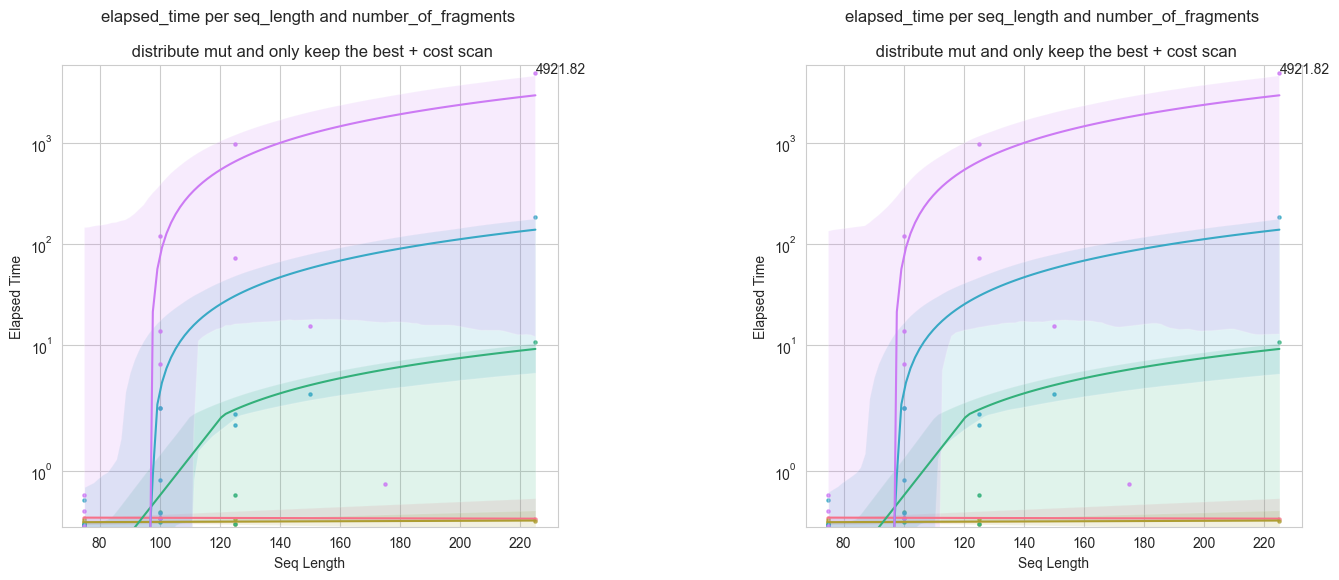

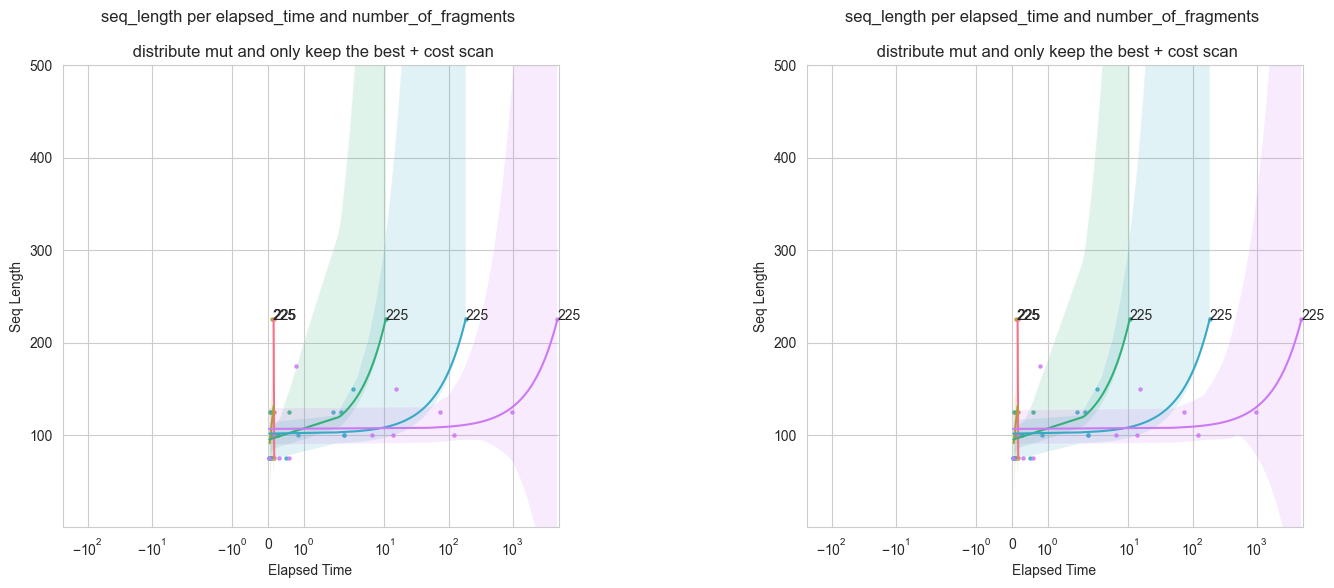

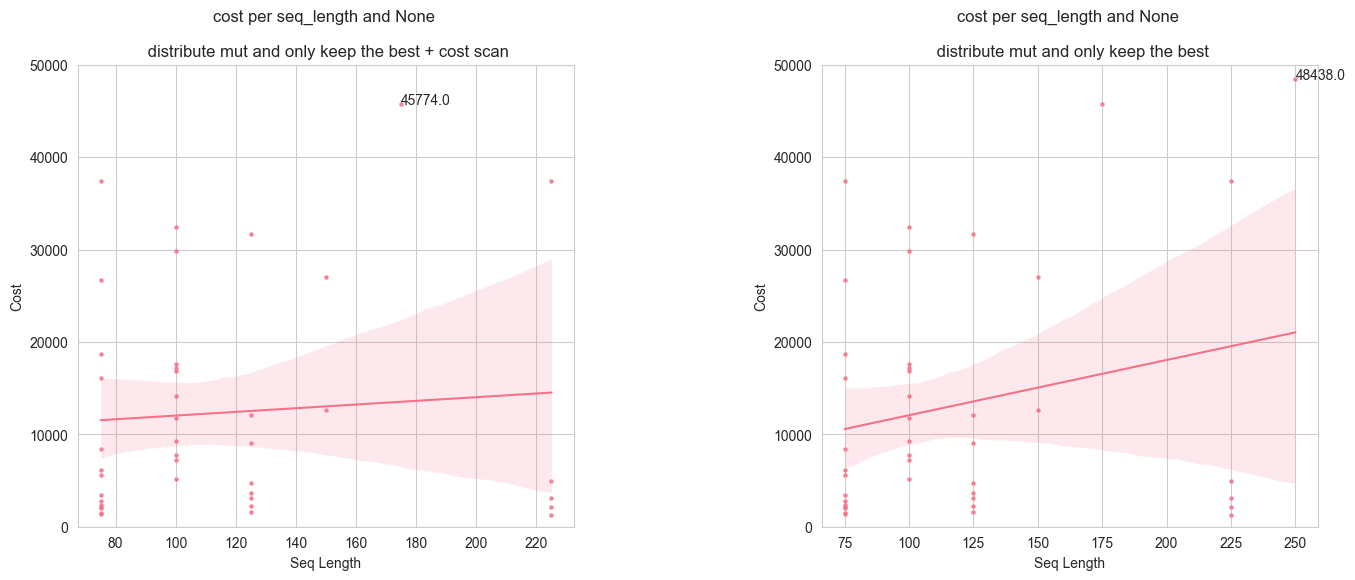

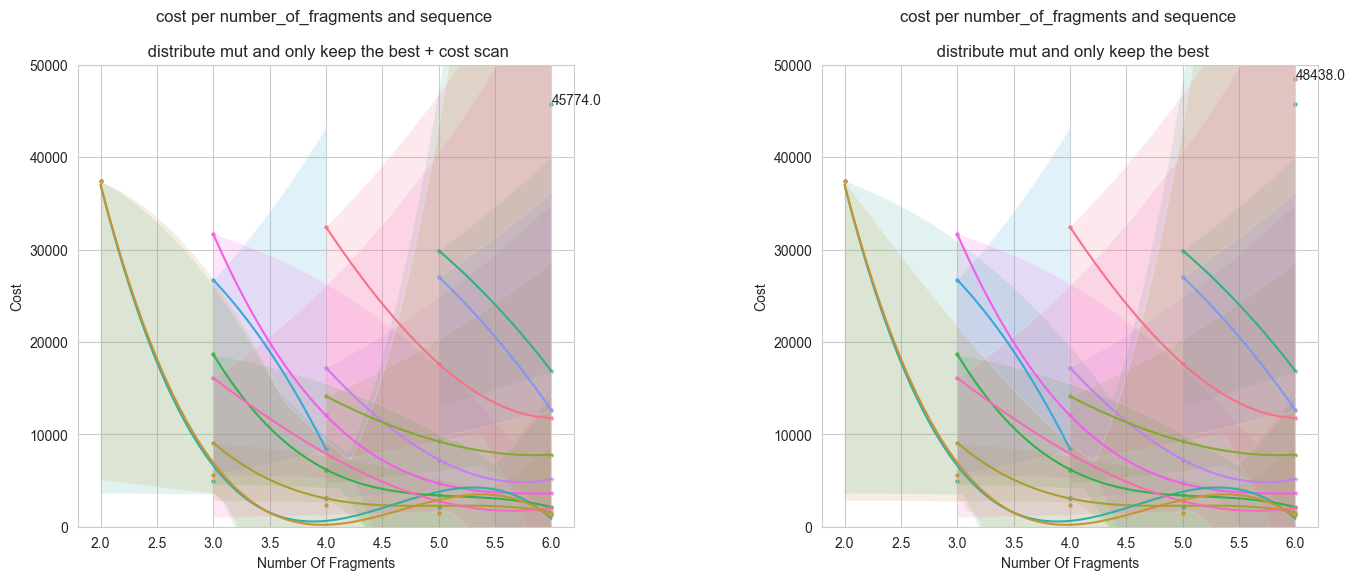

In [88]:
"""Plotting - Scatter Plots"""

search_mode1="distribute mut and only keep the best + cost scan"
search_mode2="distribute mut and only keep the best"

plt_len_time = scattered_plot(x_axis='seq_length', y_axis='elapsed_time', yscale='symlog', y_lims={search_mode1:[0.01,6000],search_mode2:[0.01,6000]}, xscale='linear', group_param="number_of_fragments", res_data=res_data, cut_number_range=range(0,6), search_mode1=search_mode1, search_mode2=search_mode1, reg_order=1)

plt_time_len = scattered_plot(x_axis='elapsed_time', y_axis='seq_length', yscale='linear', y_lims={search_mode1:[0.01,500],search_mode2:[0.01,500]}, xscale='symlog', group_param="number_of_fragments", res_data=res_data, cut_number_range=range(0,6), search_mode1=search_mode1, search_mode2=search_mode1, reg_order=1)

plt_len_cost = scattered_plot(x_axis='seq_length', y_axis='cost', yscale='linear', y_lims={search_mode1:[0,50000],search_mode2:[0,50000]}, xscale='linear', group_param=None, res_data=res_data, cut_number_range=range(0,6), search_mode1=search_mode1, search_mode2=search_mode2, reg_order=1)

plt_diversity_cost = scattered_plot(x_axis='number_of_fragments', y_axis='cost', yscale='linear', y_lims={search_mode1:[0,50000],search_mode2:[0,50000]}, xscale='linear', group_param="sequence", res_data=res_data, cut_number_range=range(0,6), search_mode1=search_mode1, search_mode2=search_mode2, reg_order=3)
